In [1]:
from itertools import chain
from operator import itemgetter
import time
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn import preprocessing
import random as rd
import string
from typing import List
import unicodedata
import torch.nn.functional as F
from torch.distributions import Categorical

## Data Processing

In [2]:
PAD_IX = 0
EOS_IX = 1
 
LETTRES = string.ascii_letters + string.punctuation + string.digits + ' '
id2lettre = dict(zip(range(2, len(LETTRES)+2), LETTRES))
id2lettre[PAD_IX] = '' ##NULL CHARACTER
id2lettre[EOS_IX] = '|'
lettre2id = dict(zip(id2lettre.values(),id2lettre.keys()))

ALPHABET_SIZE = len(LETTRES) + 2
 
 
def normalize(s):
    """ enlève les accents et les majuscules """
    return ''.join(c for c in unicodedata.normalize('NFD', s) if  c in LETTRES)
 
 
def string2code(s):
    """prend une séquence de lettres et renvoie la séquence d'entiers correspondantes"""
    return torch.tensor([lettre2id[c] for c in normalize(s)])
 
 
def code2string(t):
    """ prend une séquence d'entiers et renvoie la séquence de lettres correspondantes """
    if type(t) != list:
        t = t.tolist()
    return ''.join(id2lettre[i] for i in t)
 
 
class TextDataset(Dataset):
    def __init__(self, text: str, *, maxsent=None, maxlen=None, minlen=1):
        # self.text = text
        self.list_sentence = [sentence.strip() for sentence in text.split(".") if len(sentence) >= minlen]
        self.maxlen = maxlen
        self.maxsent = maxsent
 
    def __len__(self):
        """Returns the number of sentences in the dataset."""
        return len(self.list_sentence)
 
    def __getitem__(self, i):
        """Returns selected sentence with each character coded as an integer.
 
           Calls string2code.
           Length limited by self.maxlen.
        """
        return string2code(self.list_sentence[i][:self.maxlen])
 
 
def collate_fn(samples: List[List[int]]) -> torch.Tensor:
    """Computes a batch of sentences with paddings and EOS.
 
    Returns size length x size of batch.
    """
    length = max([len(sample) for sample in samples])
    # initialize to PAD_IX
    batch = torch.full((length + 1, len(samples)), PAD_IX, dtype=int)
    for i, sample in enumerate(samples):
        sample_len = len(sample)
        batch[:sample_len, i] = sample
        batch[sample_len, i] = EOS_IX  # add EOS
    return batch
 
 
 
if __name__ == "__main__":
    test = "C'est. Un. Test."
    ds = TextDataset(test)
    loader = DataLoader(ds, collate_fn=collate_fn, batch_size=3)
    data = next(iter(loader))
 
    # Longueur maximum
    print(data.shape)
    assert data.shape == (6, 3)  
 
    # e dans les deux cas
    assert data[2, 0] == data[1, 2]
    # les chaînes sont identiques
    assert test == " ".join([code2string(s).replace("|",".") for s in data.t()])

torch.Size([6, 3])


In [3]:
data_brute = open(r"C:\Users\jacqu\Scolarite\M2A\AMAL\data\trump_full_speech.txt", "r")
s = data_brute.read()
s_norm = normalize(s)      
dsT = TextDataset(s_norm,maxlen = 90)
loader = DataLoader(dsT, collate_fn=collate_fn, batch_size=100)
data = next(iter(loader))
print(data.shape)
print(code2string(data[:,8].tolist()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


torch.Size([91, 100])
It's great to be in a wonderful city, New York|
cuda


# RNN, GRU, LSTM

In [4]:
class RNN(nn.Module):
    def __init__(self,dim,latent,output):
        super(RNN,self).__init__()
        self.emb = torch.nn.Embedding(len(id2lettre),dim) ##embedding
        
        self.W_in = nn.Linear(dim,latent)
        self.W_hidden = nn.Linear(latent,latent)
        self.Tanh = nn.Tanh()
        
        self.decoder = nn.Linear(latent, output)


    def one_step(self,x,h):
        
        return(self.Tanh(self.W_in(x)+self.W_hidden(h)))

    def forward(self,x,h):
        x = self.emb(x[:-1]) ##Le shift se situe ici pour conserver seq_len
        
        len = x.size()[0]
        hidden = []
        for i in range(len):
            h = self.one_step(x[i],h)
            hidden.append(h)
        return(torch.stack(hidden))

    def decode(self,h):
        return(self.decoder(h))
    



class GRU(nn.Module):
    def __init__(self, dim_emb, dim_hidden, dim_out):
        super(GRU, self).__init__()
        self.dim_emb = dim_emb
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        
        self.emb = torch.nn.Embedding(len(id2lettre),dim_emb)
        self.W_z = torch.nn.Linear(dim_emb+dim_hidden,dim_hidden)
        self.W_r = torch.nn.Linear(dim_emb+dim_hidden,dim_hidden)
        self.W_h = torch.nn.Linear(dim_emb+dim_hidden,dim_hidden)
        self.Sigmo = torch.nn.Sigmoid()
        self.Tanh = torch.nn.Tanh()
        
        self.decoder = nn.Linear(dim_hidden,dim_out)
        
        
    def one_step(self,x,h):
        
        h_x = torch.cat([h,x],dim = 1)
        z_t = self.Sigmo(self.W_z(h_x))
        r_t = self.Sigmo(self.W_r(h_x))
        h_t = (1-z_t) * h + z_t * self.Tanh(self.W_h(torch.cat([r_t*h,x],dim=1)))
        return(h_t)
    
    def forward(self, x, h):
        
        x = self.emb(x[:-1]) ##comme vu précedemment
        
        len = x.size()[0]
        hidden = []
        for i in range(len):
            h = self.one_step(x[i],h)
            hidden.append(h)
        return(torch.stack(hidden))
    
    def decode(self,h):
        return(self.decoder(h))
    
    
## Je n'ai pas compris comment coder les biais, je propose une version sans biais!    
class LSTM(nn.Module):  
    def __init__(self, dim_emb, dim_hidden, dim_out,n_layers):
        super(LSTM, self).__init__()
        
        self.dim_emb = dim_emb
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.n_layers = n_layers
        
        self.emb = torch.nn.Embedding(len(id2lettre),dim_emb)
        
        self.W_f = torch.nn.Linear(dim_emb+dim_hidden,dim_hidden)
        self.W_i = torch.nn.Linear(dim_emb+dim_hidden,dim_hidden)
        self.W_o = torch.nn.Linear(dim_emb+dim_hidden,dim_hidden)
        self.W_C = torch.nn.Linear(dim_emb+dim_hidden,dim_hidden)
        self.Sigmo = torch.nn.Sigmoid()
        self.Tanh = torch.nn.Tanh()
    
        self.decoder = nn.Linear(dim_hidden,dim_out)
        
        
    def one_step(self,x,h,C):
        
        h_x = torch.cat([h,x],dim = 1)
        f_t = self.Sigmo(self.W_f(h_x))
        i_t = self.Sigmo(self.W_i(h_x))
        C_t = f_t * C + i_t * self.Tanh(self.W_C(h_x))
        o_t = self.Sigmo(self.W_o(h_x))
        h_t = o_t * self.Tanh(C_t)
        
        return(h_t,C_t)
    
    def forward(self, x, h, C):
        
        x = self.emb(x[:-1]) 
        
        len = x.size()[0]
        hidden = []
        for i in range(len):
            (h,C) = self.one_step(x[i],h,C)
            hidden.append(h)
        return(torch.stack(hidden),C)
    
    def decode(self,h):
        return(self.decoder(h))
    
    
    
def maskedCrossEntropy(out,target,padcar):
    celosses = loss(out,target)
    mask = (target != padcar)
    prod = (mask * celosses)
    celoss = prod.sum() / mask.sum()
    return (celoss)

## Train

In [5]:
nbr_epoch = 175
batch_size = 100
dim_hidden = 120
dim_emb = 60
dim_out = len(id2lettre)
eps = 2e-3
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IX)
network1 = RNN(dim_emb, dim_hidden, dim_out).to(device)
optim = torch.optim.Adam(params = network1.parameters(), lr = eps)

In [6]:
l = float('inf')
t =  0
list_loss,epoch_loss,Big_list_loss = [],[],[]
start = time.time()
for epoch in range(nbr_epoch):
    
    Big_list_loss += list_loss
    epoch_loss.append(np.mean(list_loss))
    list_loss = []
    
    for batch_ndx, sample in enumerate(loader):
        if batch_ndx == 170:
            break        
        sample = sample.to(device)
        target_data = sample[1:].long().flatten()    
        
        optim.zero_grad()
        hidden = torch.zeros((batch_size, dim_hidden))
        hidden = hidden.to(device)
        hidden = network1.forward(sample,hidden)
        out = network1.decode(hidden)

        l = criterion(out.view(-1,len(id2lettre)),target_data)
        #if batch_ndx % 50 == 0:
            #print(l)
            
        list_loss.append(float(l))
        l.backward()
        optim.step()
    
    #print("epoch loss is",np.mean(list_loss) )
stop = time.time()
print(f"Done {nbr_epoch} epoch in {(stop-start)/60 :.2} minutes.")        
    

C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Done 175 epoch in 2.5e+01 minutes.


In [7]:
batch_size = 100
dim_hidden = 120
dim_emb = 60
dim_out = len(id2lettre)
eps = 1.5e-3

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IX)
network2 = GRU(dim_emb, dim_hidden, dim_out).to(device)
optim = torch.optim.Adam(params = network2.parameters(), lr = eps)

In [8]:
l = float('inf')
t =  0
list_loss_gru,epoch_loss_gru,Big_list_loss_gru = [],[],[]
start = time.time()

for epoch in range(nbr_epoch):
    
    Big_list_loss_gru += list_loss_gru
    epoch_loss_gru.append(np.mean(list_loss_gru))
    #print("epoch loss is",np.mean(list_loss_gru) )
    list_loss_gru = []
    
    for batch_ndx, sample in enumerate(loader):
        if batch_ndx == 170:
            break        
        sample = sample.to(device)
        target_data = sample[1:].long().flatten()    
        
        optim.zero_grad()
        hidden = torch.zeros((batch_size, dim_hidden))
        hidden = hidden.to(device)
        hidden = network2.forward(sample,hidden)
        out = network2.decode(hidden)

        l = criterion(out.view(-1,len(id2lettre)),target_data)
        #if batch_ndx % 50 == 0:
            #print(l)
            
        list_loss_gru.append(float(l))
        l.backward()
        optim.step()
stop = time.time()
print(f"Done {nbr_epoch} epoch in {(stop-start)/60 :.2} minutes.")

Done 175 epoch in 5.7e+01 minutes.


In [9]:
batch_size = 100
dim_hidden = 120
dim_emb = 60
dim_out = len(id2lettre)
n_layers = 20
eps = 1.5e-3

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IX)
network3 = LSTM(dim_emb, dim_hidden, dim_out,n_layers).to(device)
optim = torch.optim.Adam(params = network3.parameters(), lr = eps)

In [10]:
start = time.time()
l = float('inf')
t =  0
list_loss_LSTM,epoch_loss_LSTM,Big_list_loss_LSTM = [],[],[]

for epoch in range(nbr_epoch):
    
    Big_list_loss_LSTM += list_loss_LSTM
    epoch_loss_LSTM.append(np.mean(list_loss_LSTM))
    #print("epoch loss is",np.mean(list_loss_LSTM) )
    list_loss_LSTM = []
    (state_h, state_c) = (torch.zeros(n_layers, 100, dim_hidden).to(device),
                torch.zeros(n_layers, 100, dim_hidden).to(device))
    
    for batch_ndx, sample in enumerate(loader):
        if batch_ndx == 170:
            break        
        sample = sample.to(device)
        target_data = sample[1:].long().flatten()
        
        optim.zero_grad()
        
        h_state = torch.zeros((batch_size, dim_hidden)).to(device)
        
        C_state = torch.zeros((batch_size, dim_hidden)).to(device)
        
        (new_h,new_C) = network3.forward(sample,h_state,C_state)

        out = network3.decode(new_h)
        
        
        l = criterion(out.view(-1,len(id2lettre)),target_data)
            
        list_loss_LSTM.append(float(l))
        l.backward()
        optim.step()
stop = time.time()
print(f"Done {nbr_epoch} epoch in {(stop-start)/60 :.2} minutes.")

Done 175 epoch in 6.5e+01 minutes.


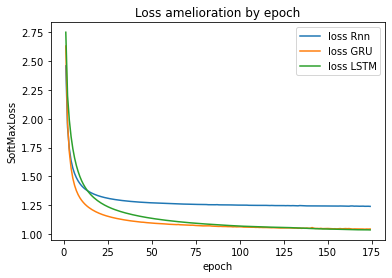

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(np.arange(len(epoch_loss)),epoch_loss,label = 'loss Rnn')
ax.plot(np.arange(len(epoch_loss_gru)),epoch_loss_gru,label = 'loss GRU')
ax.plot(np.arange(len(epoch_loss_LSTM)),epoch_loss_LSTM,label = 'loss LSTM')
ax.set_title("Loss amelioration by epoch")
ax.set_xlabel("epoch")
ax.set_ylabel("SoftMaxLoss")
ax.legend();

Les résultats sont ceux attendus : le LSTM fini par dépasser le GRU, et ils sont tout les deux biens meilleurs qu'un RNN classique

# Test

### 1) Generation de caractères

In [12]:
#Je vais générer des samples sur les meilleures estimations, les phrases sont 
#trop aléatoires sinon. C'est le Nucleus sampling.
def nucleus_sampler(probs, k):
    _, indices = torch.sort(probs)
    probs[indices.data[:-k]] = 0
    sampled_index = torch.multinomial(probs, 1)
    return sampled_index
#Le réseau Lstm prenant une entrée différente, je code deux fonctions generate

### Generation par  RNN/GRU

In [13]:
def generate_rnn(rnn, emb, decoder, eos, h, start="", maxlen=200):
    c = lettre2id[start]
    x = emb(torch.tensor(c).to(device)).view(1,60)
    h = h.to(device)
    len = 0
    text = [c]
    while (c != eos and len < maxlen):
        h = rnn.one_step(x,h)
        d = decoder(h).flatten()
        d = d.long()
        c = torch.argmax(d)
        x = emb(c).view(1,60)
        text.append(c.item())
        len += 1
    return (code2string(text))


def generate_rnn_nucl(rnn, emb, decoder, eos, h, start="",n_sample=3, maxlen=200):
    c = lettre2id[start]
    x = emb(torch.tensor(c).to(device)).view(1,60)
    h = h.to(device)
    len = 0
    text = [c]
    while (c != eos and len < maxlen):
        h = rnn.one_step(x,h)
        d = decoder(h).flatten()
        prob = nn.functional.softmax(d, dim=0).data 
        c = nucleus_sampler(prob,n_sample) ### GROS PROBLEME ICI
        x = emb(c).view(1,60)
        text.append(c.item())
        len += 1
    return (code2string(text))

In [14]:

hidden = torch.zeros((1, dim_hidden))
D = ['a','b','A','B','F','G','m','D','p','d','x','z','P','G']
for start in D:
    print(generate_rnn(network1,network1.emb,network1.decode,EOS_IX,hidden,start))
    print('vs')
    print(generate_rnn_nucl(network1,network1.emb,network1.decode,EOS_IX,hidden,start))
    
    

and it'll be a back|
vs
and it'll deals|
book and saying that we will be a great and deal and saying that we will be a great and deal and saying that we will be a great and deal and saying that we will be a great and deal and saying that we w
vs
book a commany with the people to some to said that we win the strengtor it|
And they're going to be a back|
vs
A Transing and then we also great press foreign something we're going to said, state of the people that was a governor people, they do the stat|
But they say the same country|
vs
Because the something of a group a get together of the presidence was a life my opporters, then the way, anybody|
First and deal and saying that we will be a great and deal and saying that we will be a great and deal and saying that we will be a great and deal and saying that we will be a great and deal and saying
vs
For people|
God been the people and day|
vs
God But the change and state of the people|
manked and deal and saying that we will be a great and d

In [15]:
hidden = torch.zeros((1, dim_hidden))
D = ['a','b','A','B','F','G','m','D','p','d','x','h','P','G']
for start in D:
    print(generate_rnn(network2,network2.emb,network2.decode,EOS_IX,hidden,start))
    print('vs')
    print(generate_rnn_nucl(network2,network2.emb,network2.decode,EOS_IX,hidden,start))
    
   

and safe again|
vs
and the most deals and was that's all of the stupid, we're going to st|
borth in the corruption is the best in the world|
vs
burn't thing we're going to have a great time that we have to build a li|
And then the miners are going to be a big day|
vs
And we're going to be a charted incredible|
But they're going to be a big back that has been said that it was the money|
vs
But they're not some policing into offer the same place|
First of the most important campaign in the country|
vs
First of our military is not the state|
God bless you|
vs
Go aheroo foreign policy|
mines of illegal immigrants and replace Obamacare|
vs
my failunder safe again, we are going to stand up to the wall|
Donald Trump|
vs
Donald Trump|
phation has been in the world|
vs
phole day is all of the single life, and the money|
d|
vs
dic|
xind of its manufacturing jobs since the benefitary of the |
vs
xind the same done to believe it|
hildaild Donat of my country and the best|
vs
hater was good foreign

### Generation par LSTM

In [16]:
def generate_lstm(rnn, emb, decoder, eos, h,cache, start="C", maxlen=150):
    c = lettre2id[start]
    x = emb(torch.tensor(c).to(device)).view(1,60)
    h = h.to(device)
    cache = cache.to(device)
    len = 0
    text = [c]
    while (c != eos and len < maxlen):
        h,cache = rnn.one_step(x,h,cache)
        d = decoder(h).flatten()
        d = d.long()
        c = torch.argmax(d)
        x = emb(c).view(1,60)
        text.append(c.item())
        len += 1
    return (code2string(text))

def generate_lstm_nucl(rnn, emb, decoder, eos, h,cache, start="",n_sample=3, maxlen=150):
    c = lettre2id[start]
    x = emb(torch.tensor(c).to(device)).view(1,60)
    h = h.to(device)
    cache = cache.to(device)
    len = 0
    text = [c]
    while (c != eos and len < maxlen):
        h,cache = rnn.one_step(x,h,cache)
        d = decoder(h).flatten()
        prob = nn.functional.softmax(d, dim=0).data 
        c = nucleus_sampler(prob,n_sample)
        x = emb(c).view(1,60)
        text.append(c.item())
        len += 1
    return (code2string(text))

In [17]:
hidden = torch.zeros((1, dim_hidden))
cache = torch.zeros((1,dim_hidden))
D = ['a','b','A','B','F','G','m','D','p','d','x','M','P','G']
for start in D:
    print(generate_lstm(network3,network3.emb,network3.decode,EOS_IX,hidden,cache,start))
    print('vs')
    print(generate_lstm_nucl(network3,network3.emb,network3.decode,EOS_IX,hidden,cache,start))
    
  

and more than they do it|
vs
adiliks and they're going, the people arenal|
boly about the beginning of the beginning of the beginning and they have a big deal into the same corrupt personal in the same community and getting ou
vs
but the president|
And it's going to be a states are going to be a states were all the corruption|
vs
Anybody that saying they'll heavers our jobs|
But they're all of the people of the people|
vs
But to do yesterday support the crowd|
For instance|
vs
Financhisan leaders|
God bless you|
vs
Go amone a share in the polls the middle crime is going to be there for our police|
moughed the same corrupt personal in the same community and getting our borders|
vs
moumbensia four veal people that we're going to bring back off the reason that have been safe|
Donald Trump|
vs
Doesn't they were? Thank you|
phoader|
vs
phisand many others will be about them on a long time|
dome had a campaigning|
vs
do descruping the same people will sent to the people are going in the sami

### 2) Génération de phrases: Beam-search

In [18]:
def generate_beam(rnn, emb, decoder, eos, h, k, start="", maxlen=200):
    c = lettre2id[start]
    x = emb(torch.tensor(c).to(device)).view(1,60)
    h = h.to(device)
    text = [c]
    buffer = [(text, h, 0)]
    #eos_code = string2code(eos)
    depth = 0
    n_eos = int(text[-1] == eos)
    while n_eos < len(buffer) and depth < maxlen:
        for i, (phrase, h_seq, log_likelihood) in enumerate(buffer):
            if phrase[-1] == eos:
                buffer[i] = [(phrase, h_seq, 1.05*log_likelihood)]  # it is its own and only child
            else:
                seq_emb = emb(torch.tensor(phrase[-1]).to(device)).view(1,60)
                h = rnn.one_step(seq_emb,h_seq)
                output = decoder(h).flatten()
                logits = F.log_softmax(output,dim=0)
                top_log_prob, top_codes = logits.sort(descending=True)
                # Expand parent to children
                children=[]
                for j in range(k):
                    phrase_j = phrase.copy()
                    phrase_j.append(top_codes[j].item())
                    log_likelihood_j = log_likelihood + top_log_prob[j].item()
                    children.append((phrase_j, h, log_likelihood_j))
                # Replace parent by children
                buffer[i] = children
        # Flatten
        buffer = list(chain(*buffer))
        # Top K
        buffer = sorted(buffer, key=itemgetter(2))[-k:]
        depth = max(map(lambda x: len(x[0]), buffer))
        n_eos = sum([int(phrase[-1] == eos) for phrase, _, _ in buffer])

    most_probable_sentence = buffer[0][0]
    return code2string(most_probable_sentence)

def generate_lstm_beam(rnn, emb, decoder, eos, h_test, c_test, k, start="", maxlen=200):
    char = lettre2id[start]
    x = emb(torch.tensor(char).to(device)).view(1,60)
    h = h_test.to(device)
    c = c_test.to(device)
    text = [char]
    buffer = [(text, h, c, 0)]
    #eos_code = string2code(eos)
    depth = 0
    n_eos = int(text[-1] == eos)
    while n_eos < len(buffer) and depth < maxlen:
        for i, (phrase, h_seq, c_seq, log_likelihood) in enumerate(buffer):
            if phrase[-1] == eos:
                buffer[i] = [(phrase, h_seq, c_seq, 1.05*log_likelihood)]  # it is its own and only child
            else:
                seq_emb = emb(torch.tensor(phrase[-1]).to(device)).view(1,60)
                h,c = rnn.one_step(seq_emb,h_seq,c_seq)
                output = decoder(h).flatten()
                logits = F.log_softmax(output,dim=0)
                top_log_prob, top_codes = logits.sort(descending=True)
                # Expand parent to children
                children=[]
                for j in range(k):
                    phrase_j = phrase.copy()
                    phrase_j.append(top_codes[j].item())
                    log_likelihood_j = log_likelihood + top_log_prob[j].item()
                    children.append((phrase_j, h, c, log_likelihood_j))
                # Replace parent by children
                buffer[i] = children
        # Flatten
        buffer = list(chain(*buffer))
        # Top K
        buffer = sorted(buffer, key=itemgetter(3))[-k:]
        depth = max(map(lambda x: len(x[0]), buffer))
        n_eos = sum([int(phrase[-1] == eos) for phrase, _, _, _ in buffer])

    phrases = [(code2string(phrase), log_like) for phrase,_,_,log_like in buffer]
    most_probable_sentence = buffer[-1][0]
    return code2string(most_probable_sentence)


In [19]:
start = 'D'
hidden = torch.zeros((1,dim_hidden))
cache = torch.zeros((1,dim_hidden))
print(generate_beam(network2,network2.emb,network2.decode,EOS_IX,hidden,3,start))
print(generate_lstm_beam(network3,network3.emb,network3.decode,EOS_IX,hidden,cache,3,start))
    

Donald Trump, they're going to be the most important country and they're going to get the single|
Don't believe them to the same people that we're going to have the same going to happen and it's going to be so many others will never believe in the same people that we're going to believe this in th
